In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import pydicom
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
class PneumothoraxDataset(Dataset):
    def __init__(self, image_ids, train_rle, dicom_path, transform=None):
        """
        Args:
            image_ids: 사용할 이미지 ID 리스트
            train_rle: RLE 정보가 담긴 DataFrame
            dicom_path: DICOM 파일 경로 (Path 객체)
            transform: Augmentation
        """
        self.train_rle = train_rle
        self.transform = transform

        
        # 모든 .dcm 파일 찾기 (한 번만 실행)
        all_files = list(dicom_path.rglob('*.dcm'))
        print(f"   전체 DICOM 파일 수: {len(all_files)}")
        
        # 딕셔너리로 저장: {image_id: file_path}
        self.file_paths = {}
        for file_path in tqdm(all_files, desc="인덱싱"):
            img_id = file_path.stem  # 파일명에서 확장자 제거
            self.file_paths[img_id] = file_path
        
        # 실제로 파일이 있는 image_id만 필터링
        valid_ids = []
        missing_ids = []
        
        for img_id in image_ids:
            if img_id in self.file_paths:
                valid_ids.append(img_id)
            else:
                missing_ids.append(img_id)
        
        if missing_ids:
            if len(missing_ids) <= 5:
                print(f"   누락된 ID: {missing_ids}")
            else:
                print(f"   누락된 ID 예시: {missing_ids[:5]}")
        
        self.image_ids = valid_ids
        print(f"{len(self.file_paths)}개 파일")
        print(f"{len(self.image_ids)}개\n")

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]

        file_path = self.file_paths[img_id]
        
        # DICOM 파일 읽기
        dcm = pydicom.dcmread(file_path)
        image = dcm.pixel_array

        # 정규화 (0-255 -> 0-1)
        if image.max() > 0:  # 0으로 나누기 방지
            image = image.astype(np.float32) / image.max()
        else:
            image = image.astype(np.float32)
        
        image = np.stack([image, image, image], axis=-1)  # Grayscale -> RGB

        # 마스크 로드
        rle = self.train_rle[self.train_rle['ImageId'] == img_id][' EncodedPixels'].values[0]

        # Negative 샘플인 경우 빈 마스크 생성
        if rle == '-1' or pd.isna(rle):
            mask = np.zeros((1024, 1024), dtype=np.float32)
        else:
            mask = rle_decode(rle, 1024, 1024).astype(np.float32)

        # Augmentation
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        mask = mask.unsqueeze(0)  # (H, W) -> (1, H, W)
        return image, mask

In [31]:
def rle_decode(rle, width, height):
    if pd.isna(rle) or str(rle).strip() == '-1':
        return np.zeros((height, width), dtype=np.uint8)

    array = np.asarray([int(x) for x in str(rle).strip().split()]) #RLE 문자열 -> int 리스트
    starts = array[0::2] #짝수 인덱스값 : mask 픽셀 사이 간격
    lengths = array[1::2] #홀수 인덱스 : mask 길이

    current_position = 0
    mask = np.zeros(width * height, dtype=np.uint8)

    for start, length in zip(starts, lengths):
        current_position += start
        mask[current_position:current_position+length] = 1
        current_position += length

    return mask.reshape(width, height).T

In [ ]:
# Augmentation : 수정하기
train_transform = A.Compose([
    A.Resize(128, 128), #크기 키우기
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
    #elastice deformation
])

val_transform = A.Compose([
    A.Resize(128, 128),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

C:\Users\sua10\AppData\Roaming\Python\Python311\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [33]:
from pathlib import Path

train_rle = pd.read_csv('pneumothorax_data/train-rle.csv')
train_dicom_path = Path('pneumothorax_data/dicom-images-train')

train_rle['has_pneumothorax'] = (train_rle[' EncodedPixels'] != ' -1')

In [48]:
all_ids = train_rle['ImageId'].values[:100]

print(f"전체 데이터 수 : {len(all_ids)}")
print(f"Positive 샘플 수 : {train_rle['has_pneumothorax'].sum()}")
print(f"Negative 샘플 수 : {(~train_rle['has_pneumothorax']).sum()}")

#20%는 validation용
train_ids, val_ids = train_test_split(all_ids, test_size=0.2, random_state=42)

train_dataset = PneumothoraxDataset(train_ids, train_rle, train_dicom_path, train_transform)
val_dataset = PneumothoraxDataset(val_ids, train_rle, train_dicom_path, val_transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=0)

print(f"\n전체 학습 데이터 수: {len(train_dataset)}")
print(f"전체 검증 데이터 수: {len(val_dataset)}")
print(f"학습 배치 수: {len(train_loader)}")
print(f"검증 배치 수: {len(val_loader)}")

전체 데이터 수 : 100
Positive 샘플 수 : 3286
Negative 샘플 수 : 8296
   전체 DICOM 파일 수: 10712


인덱싱: 100%|██████████| 10712/10712 [00:00<00:00, 653271.26it/s]

10712개 파일
80개



   전체 DICOM 파일 수: 10712


인덱싱: 100%|██████████| 10712/10712 [00:00<00:00, 330625.68it/s]

10712개 파일
20개


전체 학습 데이터 수: 80
전체 검증 데이터 수: 20
학습 배치 수: 1
검증 배치 수: 1


In [49]:
# # Pretrained U-Net
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model = smp.Unet(
#     encoder_name="resnet34",        # Backbone
#     encoder_weights="imagenet",     # Pretrained weights
#     in_channels=3,                  # RGB
#     classes=1,                      # Binary segmentation
# )
# model = model.to(device)

In [50]:
from models.unet import UNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(
    in_channels=3,      # RGB 입력
    n_classes=1,        # Binary segmentation
    # 다른 파라미터들은 해당 클래스의 __init__ 확인 필요
)
model = model.to(device)

In [ ]:
criterion = smp.losses.DiceLoss(mode='binary')
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.99)
#optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)

In [52]:
def dice_coefficient(pred, target, smooth=1e-6):
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

In [53]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    total_dice = 0

    for images, masks in tqdm(loader):
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_dice += dice_coefficient(torch.sigmoid(outputs), masks).item()

    return total_loss / len(loader), total_dice / len(loader)

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    total_dice = 0

    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            total_loss += loss.item()
            total_dice += dice_coefficient(torch.sigmoid(outputs), masks).item()

    return total_loss / len(loader), total_dice / len(loader)

In [54]:
print(f"전체 학습 데이터 수: {len(train_dataset)}")
print(f"Batch size: {train_loader.batch_size}")
print(f"전체 배치 수: {len(train_loader)}")

전체 학습 데이터 수: 80
Batch size: 128
전체 배치 수: 1


In [55]:
num_epochs = 2
best_dice = 0

for epoch in range(num_epochs):
    train_loss, train_dice = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_dice = validate(model, val_loader, criterion, device)

    scheduler.step(val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}')

    if val_dice > best_dice:
        best_dice = val_dice
        torch.save(model.state_dict(), 'best_unet.pth')
        print(f'Model saved. Best Dice: {best_dice:.4f}')
    print()

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:45<00:00, 45.25s/it]


Epoch 1/2
Train Loss: 0.9895, Train Dice: 0.0118
Val Loss: 0.9851, Val Dice: 0.0000
Model saved. Best Dice: 0.0000



100%|██████████| 1/1 [00:37<00:00, 37.15s/it]


Epoch 2/2
Train Loss: 0.9890, Train Dice: 0.0125
Val Loss: 0.9852, Val Dice: 0.0000



C:\Users\sua10\AppData\Local\Temp\ipykernel_46560\568791969.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_unet.pth'))


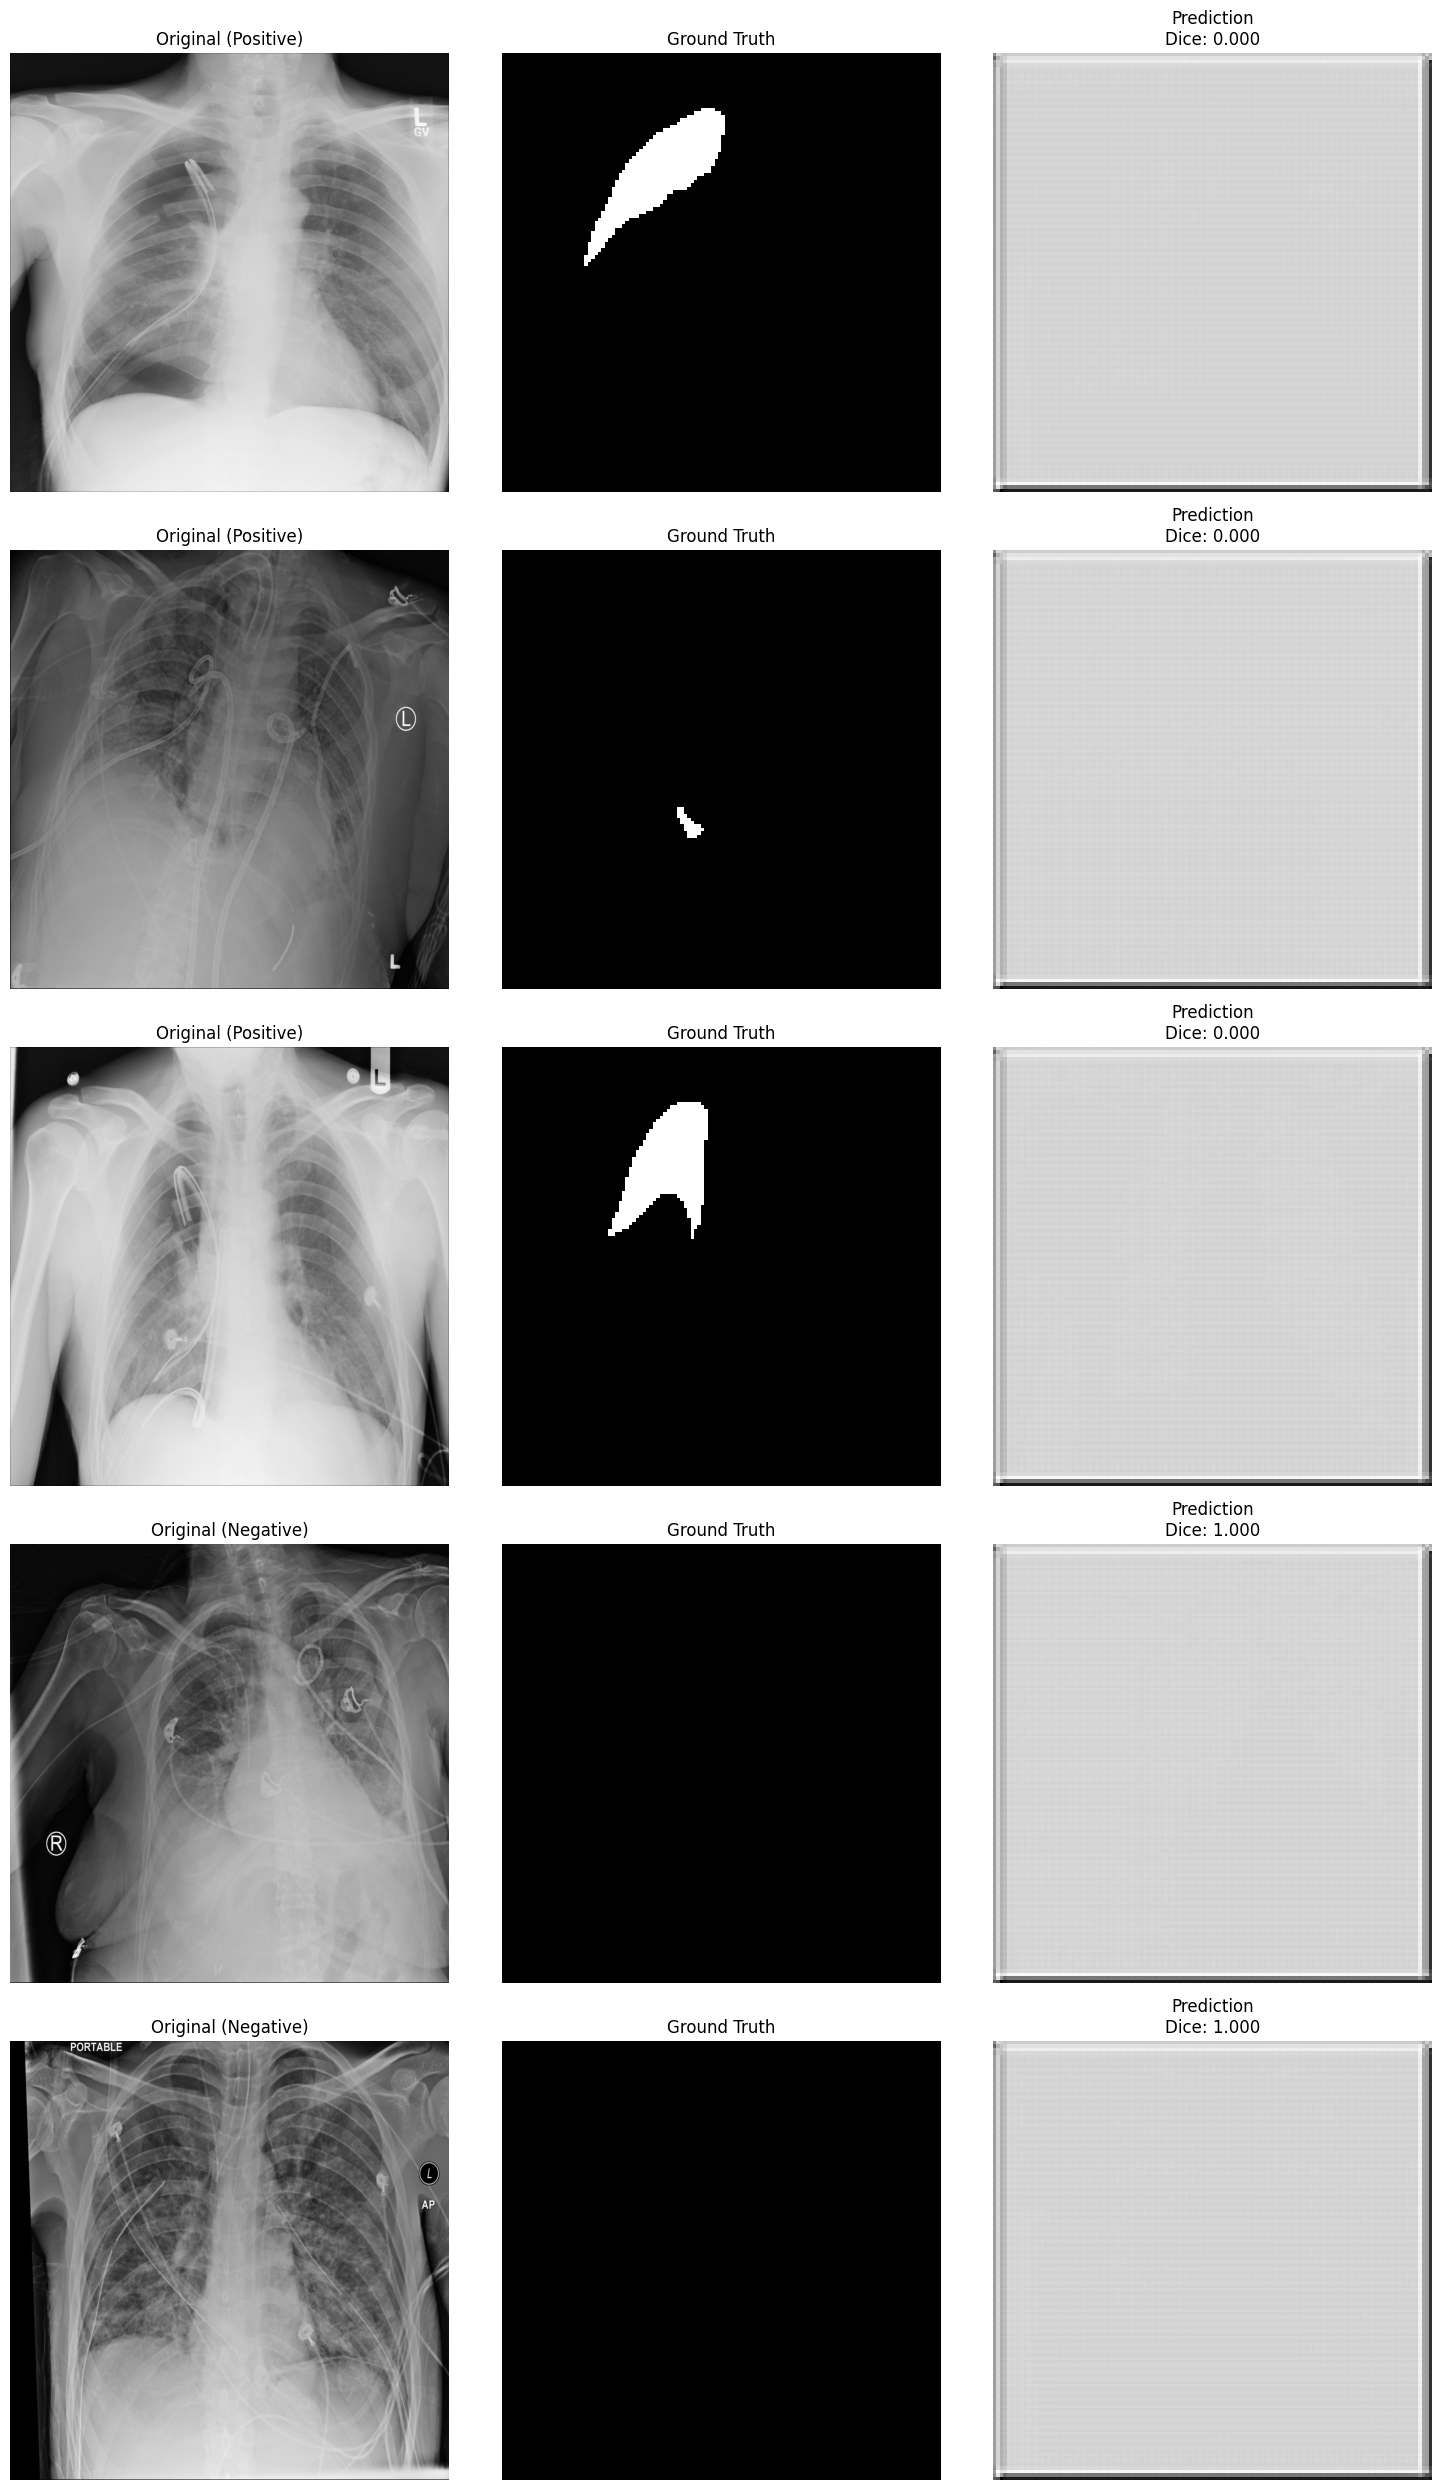

In [56]:
model.load_state_dict(torch.load('best_unet.pth'))
model.eval()

positive_indices = []
negative_indices = []

for idx in range(len(val_dataset)):
    _, mask = val_dataset[idx]
    if mask.sum() > 0:
        positive_indices.append(idx)
    else:
        negative_indices.append(idx)
    
    if len(positive_indices) >= 3 and len(negative_indices) >= 2:
        break

sample_indices = positive_indices[:3] + negative_indices[:2]

fig, axes = plt.subplots(5, 3, figsize=(15, 25))

with torch.no_grad():
    for i, idx in enumerate(sample_indices):

        img_id = val_dataset.image_ids[idx]
        file_path = val_dataset.file_paths[img_id]  # 딕셔너리에서 가져오기
        
        dcm = pydicom.dcmread(file_path)
        raw_image = dcm.pixel_array
        
        # 시각화용 원본 이미지 (정규화 안된 것)
        img_show = raw_image.astype(np.float32)
        img_show = (img_show - img_show.min()) / (img_show.max() - img_show.min())
        
        # 모델 예측용 (정규화된 것)
        image, mask = val_dataset[idx]
        image_input = image.unsqueeze(0).to(device)
        
        pred = model(image_input)
        pred = torch.sigmoid(pred).cpu().squeeze().numpy()
        
        sample_type = "Positive" if mask.sum() > 0 else "Negative"
        
        # Original 이미지
        axes[i, 0].imshow(img_show, cmap='gray')
        axes[i, 0].set_title(f'Original ({sample_type})')
        axes[i, 0].axis('off')
        
        # Ground Truth
        axes[i, 1].imshow(mask.squeeze(), cmap='gray')
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')
        
        # Prediction
        axes[i, 2].imshow(pred, cmap='gray')
        dice_score = dice_coefficient(torch.tensor(pred), mask).item()
        axes[i, 2].set_title(f'Prediction\nDice: {dice_score:.3f}')
        axes[i, 2].axis('off')

plt.tight_layout()
plt.savefig('predictions.png', dpi=150, bbox_inches='tight')
plt.show()